In [47]:
# imports cell
import numpy as np
import pandas as pd
import _pickle as pk
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings

# to create a tensor on the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [48]:
filename = "D:\Projects\Python_Projects\ML\ModulationClassification_Pytorch\RML2016.10b\RML2016.10b.dat"
open_file = open(filename, 'rb')
data = pk.load(open_file, encoding='latin1')

In [49]:
signals_df = pd.DataFrame(list(data.items()), columns=['Key', 'Data'])
signals_df['Label'], signals_df['SNR'] = signals_df.Key.str
signals_df

,Key,Data,Label,SNR
0,"(QPSK, 2)","[[[-0.0075228056, -0.0056156227, -0.004400276,...",QPSK,2
1,"(PAM4, 8)","[[[0.00048308217, -0.00052503555, 0.0005379811...",PAM4,8
2,"(AM-DSB, -4)","[[[0.001359591, 0.0030759352, -0.0070046755, -...",AM-DSB,-4
3,"(GFSK, 6)","[[[0.0024218021, 0.001641912, 0.00010403033, -...",GFSK,6
4,"(QAM64, 8)","[[[-0.0047246083, -0.004052764, -0.002794009, ...",QAM64,8
...,...,...,...,...
195,"(QPSK, -4)","[[[-0.003440612, -0.0059135226, 0.0031228333, ...",QPSK,-4
196,"(8PSK, -2)","[[[0.008129765, 0.01309299, -0.002217424, 0.00...",8PSK,-2
197,"(GFSK, -12)","[[[0.003865175, -0.0034481273, 0.0036327532, -...",GFSK,-12
198,"(8PSK, 6)","[[[0.006229489, -0.0031945696, 0.005326481, -0...",8PSK,6


In [50]:
SNR_list = np.sort(signals_df.SNR.unique())
Classes = signals_df.Label.unique()

SNR_list, Classes

(array([-20, -18, -16, -14, -12, -10,  -8,  -6,  -4,  -2,   0,   2,   4,
          6,   8,  10,  12,  14,  16,  18], dtype=int64),
 array(['QPSK', 'PAM4', 'AM-DSB', 'GFSK', 'QAM64', 'QAM16', '8PSK', 'WBFM',
        'BPSK', 'CPFSK'], dtype=object))

In [51]:
snr_0 = signals_df[signals_df['SNR'] == SNR_list[10]]
snr_0

,Key,Data,Label,SNR
22,"(CPFSK, 0)","[[[0.008498599, 0.0032935098, 0.009257533, -0....",CPFSK,0
44,"(WBFM, 0)","[[[-0.0001971325, 0.005053609, -0.0011216417, ...",WBFM,0
55,"(BPSK, 0)","[[[0.0024843407, 0.0058399215, 0.00029465533, ...",BPSK,0
73,"(8PSK, 0)","[[[0.004954453, -0.0025108524, -0.006107292, 0...",8PSK,0
77,"(GFSK, 0)","[[[0.0070821354, 0.0045982446, 0.0061556743, -...",GFSK,0
80,"(QAM16, 0)","[[[0.0017232103, -0.0062997793, -0.019598406, ...",QAM16,0
106,"(PAM4, 0)","[[[-0.00017230351, 0.0024808664, -0.0003051981...",PAM4,0
110,"(QAM64, 0)","[[[0.00039049715, -0.0014383754, -0.0007713570...",QAM64,0
120,"(QPSK, 0)","[[[-0.0027371016, 0.0024517025, 0.0027217618, ...",QPSK,0
146,"(AM-DSB, 0)","[[[0.003235979, 0.00036907254, 0.0030784816, -...",AM-DSB,0


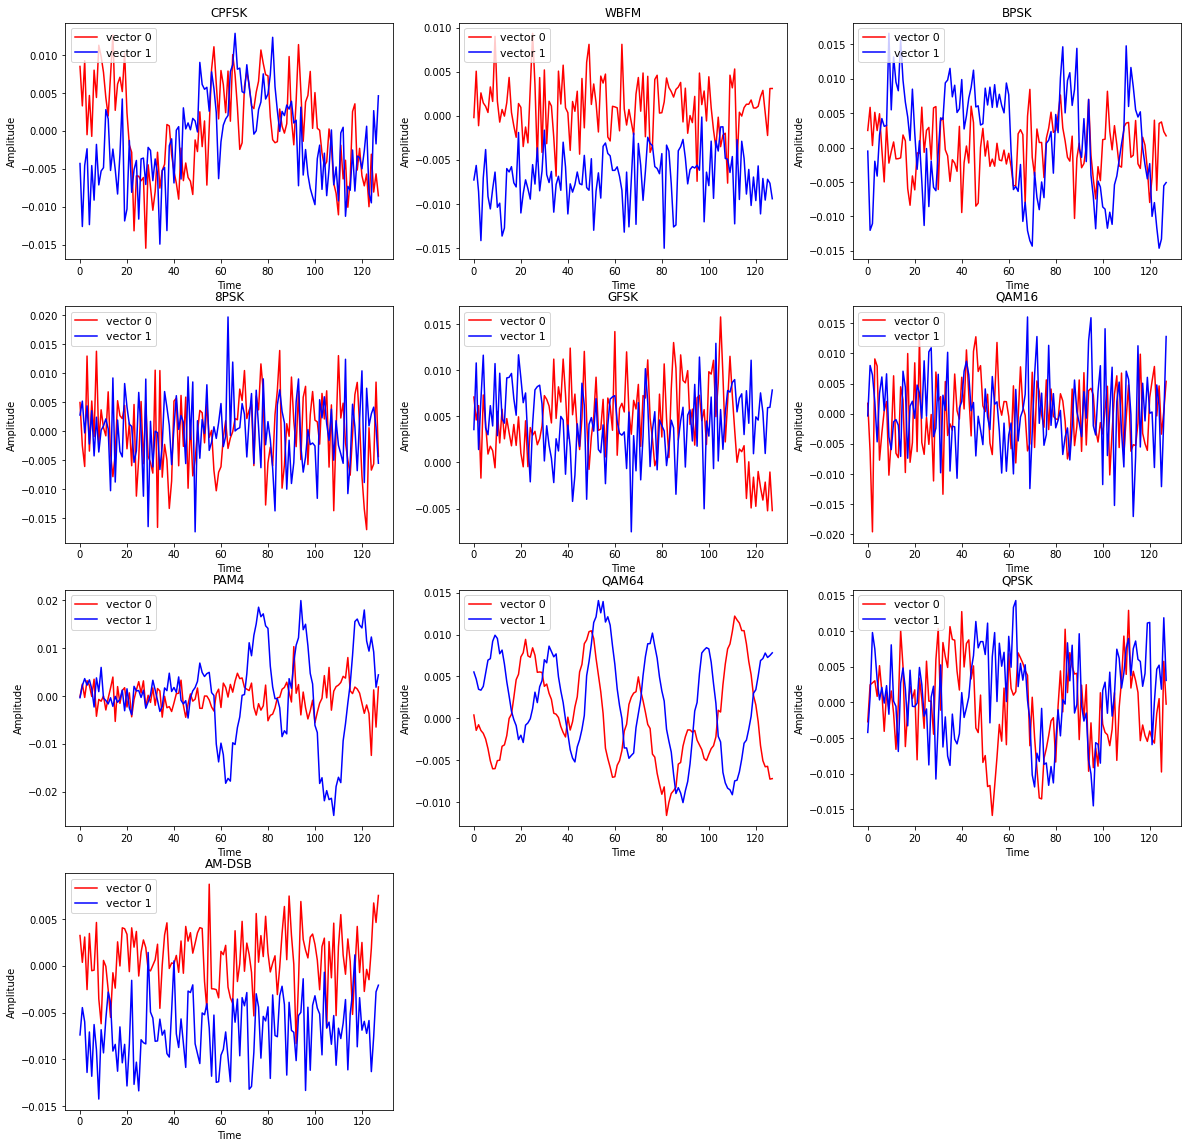

In [69]:
plt.figure(figsize=(20, 20))

for i in range(len(snr_0)):
    plt.subplot(4, 3, i + 1)
    plt.plot(snr_0['Data'].iloc[i][0][0], color='red', label='vector 0')
    plt.plot(snr_0['Data'].iloc[i][0][1], color='blue', label='vector 1')
    plt.legend(loc='upper left', fontsize=11)
    plt.title(snr_0['Label'].iloc[i])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')


In [53]:
x = []
y = []

for i in range(len(snr_0)):
    data_array = snr_0['Data'].iloc[i]
    label = snr_0['Label'].iloc[i]
    for j in range(data_array.shape[0]):
        x.append(data_array[j])
        y.append(label)

x = np.array(x)
le = LabelEncoder()
y = le.fit_transform(y)
y = np.array(y)


In [54]:
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

In [55]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.05, stratify=y_train_val)

In [56]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((39900, 2, 128), (39900,), (2100, 2, 128), (2100,), (18000, 2, 128), (18000,))

In [58]:
class MyDataset(Dataset):
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.array[index], dtype=torch.float32, device=device), torch.tensor(self.labels[index],
                                                                                                 device=device)  #,device=device

    def __len__(self):
        return len(self.array)

In [59]:
trainDataset = MyDataset(x_train, y_train)

train_dataloader = DataLoader(trainDataset, batch_size=2048, shuffle=True)  # ,num_workers=1,pin_memory=True

In [60]:
valDataset = MyDataset(x_val, y_val)

val_dataloader = DataLoader(valDataset, batch_size=2048, shuffle=True)

In [61]:
testDataset = MyDataset(x_test, y_test)

test_dataloader = DataLoader(testDataset, batch_size=2048, shuffle=True)

In [62]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # output size : (width - filter + 2*padding)/stride +1
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=16, kernel_size=3, stride=2)

        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(992, 128)  # dim c * w* h
        self.fc2 = nn.Linear(128, 10)

    def forward(self, data):
        data = self.conv1(data)
        data = F.relu(data)

        data = self.conv2(data)
        data = F.relu(data)

        data = torch.flatten(data, 1)
        #data = self.dropout(data)

        data = self.fc1(data)
        data = F.relu(data)

        data = self.fc2(data)

        return data

In [63]:
def train_model(model, dataloader, optimizer):
    model.train()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    for (data, label) in dataloader:
        # forward pass
        output = model(data)

        _, predicted = torch.max(output.data, 1)

        # compute loss
        loss_ = loss(output, label)
        total_loss += loss_.item()

        # reset gradients (it will accumulate gradients otherwise)
        optimizer.zero_grad()

        # backward propagation dl/dw -> gradients
        loss_.backward()

        # update weights
        optimizer.step()

        pred += predicted.tolist()
        labels += label.tolist()

    return accuracy_score(labels, pred) * 100, total_loss / len(dataloader)

In [64]:
def test_model(model, dataloader):
    model.eval()

    pred = []
    labels = []
    loss = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for (data, label) in dataloader:
            output = model(data)

            _, predicted = torch.max(output.data, 1)

            # compute loss
            loss_ = loss(output, label)
            total_loss += loss_.item()

            pred += predicted.tolist()
            labels += label.tolist()

    return labels, pred, accuracy_score(labels, pred) * 100, total_loss / len(dataloader)

In [65]:
model = CNN_Model().cuda()
#model.load_state_dict(torch.load(model_path))

epoch = 100

# about 5000 sample and batch size = 16 then 5000/16 ~= 300 iteration per epoch

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, threshold=0.001)

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

In [66]:
# Train and validate model

for e in range(epoch):
    train_accuracy, train_loss = train_model(model, train_dataloader, optimizer)

    val_labels, val_pred, val_accuracy, val_loss = test_model(model, val_dataloader)

    # Decay Learning Rate
    scheduler.step(val_loss)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

    print('epoch: ', e + 1, '\nTraining loss: ', train_loss, 'Training Accuracy: ', train_accuracy, '%', '  Val loss: ',
          val_loss, 'Val Accuracy: ', val_accuracy, '%')
    print('learning rate :', optimizer.state_dict()['param_groups'][0]['lr'], '\n')


epoch:  1 
Training loss:  2.303064429759979 Training Accuracy:  9.849624060150376 %   Val loss:  2.3018624782562256 Val Accuracy:  10.0 %
learning rate : 0.001 

epoch:  2 
Training loss:  2.3027172088623047 Training Accuracy:  10.097744360902256 %   Val loss:  2.302211880683899 Val Accuracy:  10.0 %
learning rate : 0.001 

epoch:  3 
Training loss:  2.302448797225952 Training Accuracy:  11.228070175438596 %   Val loss:  2.303303837776184 Val Accuracy:  10.0 %
learning rate : 0.001 

epoch:  4 
Training loss:  2.3023123264312746 Training Accuracy:  10.177944862155389 %   Val loss:  2.301508069038391 Val Accuracy:  17.80952380952381 %
learning rate : 0.001 

epoch:  5 
Training loss:  2.2999077677726745 Training Accuracy:  13.333333333333334 %   Val loss:  2.2992557287216187 Val Accuracy:  10.095238095238095 %
learning rate : 0.001 

epoch:  6 
Training loss:  2.282319390773773 Training Accuracy:  10.957393483709273 %   Val loss:  2.249174952507019 Val Accuracy:  13.476190476190474 %
l

In [67]:
# test model

test_labels, test_pred, test_accuracy, test_loss = test_model(model, test_dataloader)
print('Test loss: ', test_loss, 'Test Accuracy: ', test_accuracy, '%')
print('\n', classification_report(test_labels, test_pred))
print('\n', confusion_matrix(test_labels, test_pred))


Test loss:  1.8525525993771024 Test Accuracy:  24.099999999999998 %

               precision    recall  f1-score   support

           0       0.14      0.34      0.20      1800
           1       0.52      0.69      0.60      1800
           2       0.14      0.05      0.07      1800
           3       0.17      0.12      0.14      1800
           4       0.35      0.59      0.44      1800
           5       0.14      0.17      0.15      1800
           6       0.20      0.01      0.02      1800
           7       0.15      0.08      0.10      1800
           8       0.16      0.21      0.18      1800
           9       0.37      0.15      0.22      1800

    accuracy                           0.24     18000
   macro avg       0.23      0.24      0.21     18000
weighted avg       0.23      0.24      0.21     18000


 [[ 603    0   90  146  155  252    7  146  399    2]
 [  58 1247    1   11  175   24    0    7   12  265]
 [ 679    0   88  151  204  259   13  104  298    4]
 [ 462    

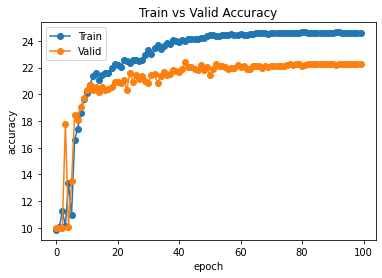

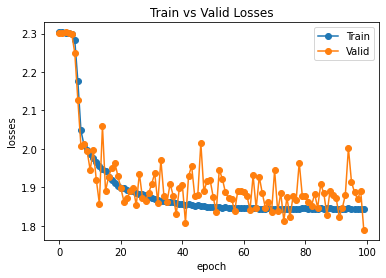

In [68]:
plt.plot(train_acc_list, '-o')
plt.plot(val_acc_list, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

plt.plot(train_loss_list, '-o')
plt.plot(val_loss_list, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses')

plt.show()